In [6]:
# 1Ô∏è‚É£ Import
import pandas as pd
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster
from scipy.signal import find_peaks
import numpy as np
import matplotlib.dates as mdates

Found Head & Shoulders at index 10
Found Head & Shoulders at index 39
Found Inverse Head & Shoulders at index 29

Found 3 patterns for PTT.BK


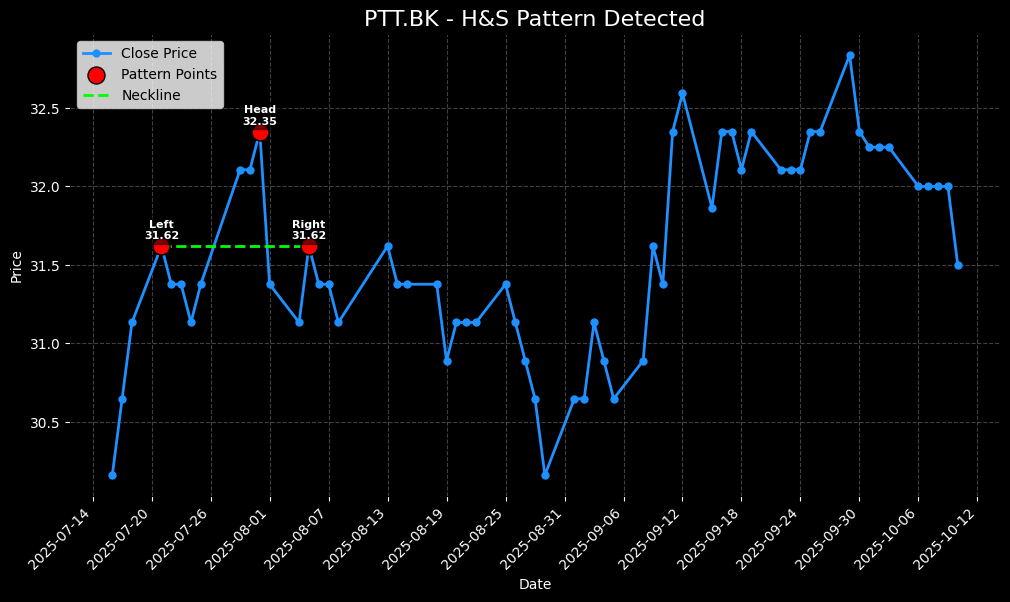

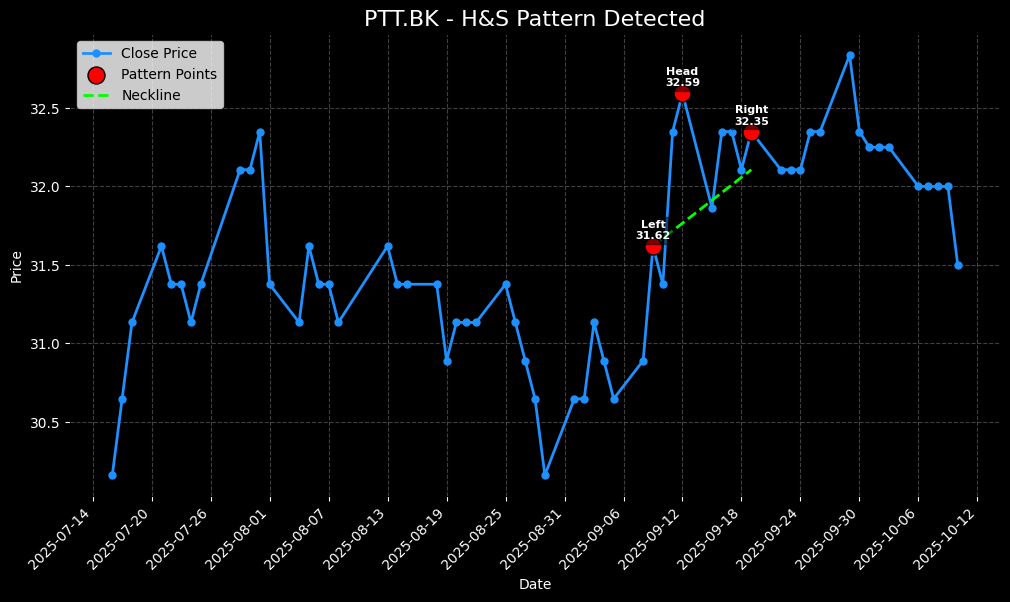

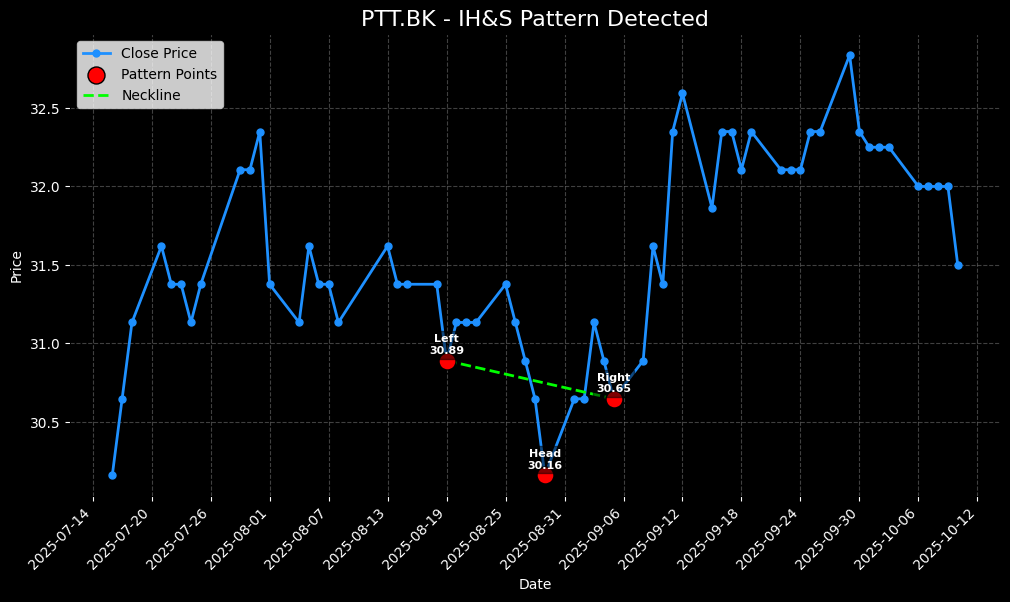

In [11]:

# 2Ô∏è‚É£ ‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏≤‡∏Å Cassandra (30 ‡∏ß‡∏±‡∏ô‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î)
def get_candlestick_data(symbol: str, days: int = 30):
    cluster = Cluster(['127.0.0.1'], port=9042)
    session = cluster.connect('data_stock')  # keyspace ‡∏Ç‡∏≠‡∏á‡∏Ñ‡∏∏‡∏ì

    # ‡∏™‡∏°‡∏°‡∏ï‡∏¥‡∏ß‡πà‡∏≤‡πÄ‡∏ß‡∏•‡∏≤‡∏ó‡∏µ‡πà‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡πÄ‡∏õ‡πá‡∏ô timestamp ‡πÅ‡∏•‡πâ‡∏ß‡πÄ‡∏£‡∏µ‡∏¢‡∏á DESC
    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol = '{symbol}'
        ORDER BY time DESC
        LIMIT {days}
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)

    df = df.sort_values('time')  # ‡πÄ‡∏£‡∏µ‡∏¢‡∏á‡∏à‡∏≤‡∏Å‡πÄ‡∏Å‡πà‡∏≤ ‚Üí ‡πÉ‡∏´‡∏°‡πà
    df.columns = df.columns.str.strip().str.lower()  # ‡∏•‡πâ‡∏≤‡∏á‡∏ä‡∏∑‡πà‡∏≠‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå
    df.rename(columns={
        'open_price': 'open',
        'high_price': 'high',
        'low_price': 'low',
        'close_price': 'close'
    }, inplace=True)

    df.set_index('time', inplace=True)
    return df

# 3Ô∏è‚É£ ‡∏ü‡∏±‡∏á‡∏Å‡πå‡∏ä‡∏±‡∏ô‡∏ï‡∏£‡∏ß‡∏à‡∏à‡∏±‡∏ö H&S (‡πÄ‡∏´‡∏°‡∏∑‡∏≠‡∏ô‡πÄ‡∏î‡∏¥‡∏°)
def detect_head_shoulders(df, distance=5, tolerance=0.03, debug=False):
    prices = df['close'].values
    peaks, _ = find_peaks(prices, distance=distance)
    troughs, _ = find_peaks(-prices, distance=distance)

    patterns = []

    # Head & Shoulders
    for i in range(2, len(peaks)):
        l, h, r = peaks[i-2], peaks[i-1], peaks[i]
        left, head, right = prices[l], prices[h], prices[r]
        if head > left and head > right and abs(left - right) / head < tolerance:
            neck_left = min(prices[l:h])
            neck_right = min(prices[h:r])
            neck_slope = (neck_right - neck_left) / (r - l)
            post_pattern = prices[r:]
            neckline_series = neck_right + neck_slope * np.arange(1, len(post_pattern) + 1)
            if (post_pattern < neckline_series).any():
                patterns.append({
                    "type": "H&S",
                    "left_idx": l,
                    "head_idx": h,
                    "right_idx": r,
                    "neck_slope": neck_slope,
                    "break_idx": r + np.where(post_pattern < neckline_series)[0][0],
                })
                if debug:
                    print(f"Found Head & Shoulders at index {h}")

    # Inverse Head & Shoulders
    for i in range(2, len(troughs)):
        l, h, r = troughs[i-2], troughs[i-1], troughs[i]
        left, head, right = prices[l], prices[h], prices[r]
        if head < left and head < right and abs(left - right) / head < tolerance:
            neck_left = max(prices[l:h])
            neck_right = max(prices[h:r])
            neck_slope = (neck_right - neck_left) / (r - l)
            post_pattern = prices[r:]
            neckline_series = neck_right + neck_slope * np.arange(1, len(post_pattern) + 1)
            if (post_pattern > neckline_series).any():
                patterns.append({
                    "type": "IH&S",
                    "left_idx": l,
                    "head_idx": h,
                    "right_idx": r,
                    "neck_slope": neck_slope,
                    "break_idx": r + np.where(post_pattern > neckline_series)[0][0],
                })
                if debug:
                    print(f"Found Inverse Head & Shoulders at index {h}")

    return patterns

# 4Ô∏è‚É£ ‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô 50 ‡∏ß‡∏±‡∏ô‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î (‡∏™‡πà‡∏ß‡∏ô‡∏ô‡∏µ‡πâ‡πÄ‡∏´‡∏°‡∏∑‡∏≠‡∏ô‡πÄ‡∏î‡∏¥‡∏°)
symbol = "PTT.BK"
df = get_candlestick_data(symbol, days=60)
patterns = detect_head_shoulders(df, distance=3, tolerance=0.05, debug=True)

print(f"\nFound {len(patterns)} patterns for {symbol}")

# 5Ô∏è‚É£ ‡πÅ‡∏™‡∏î‡∏á‡∏Å‡∏£‡∏≤‡∏ü
# ‡∏ñ‡πâ‡∏≤‡∏°‡∏µ pattern ‡∏°‡∏≤‡∏Å‡∏Å‡∏ß‡πà‡∏≤ 3 ‡πÉ‡∏´‡πâ‡πÄ‡∏≠‡∏≤‡πÅ‡∏Ñ‡πà 3 ‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î


for p in patterns:
    plt.figure(figsize=(12,6))
    
    # ‡∏ß‡∏≤‡∏î‡πÄ‡∏™‡πâ‡∏ô‡∏£‡∏≤‡∏Ñ‡∏≤
    # üî¥ ‡πÅ‡∏Å‡πâ‡πÑ‡∏Ç: ‡πÄ‡∏û‡∏¥‡πà‡∏° marker='.' (‡∏à‡∏∏‡∏î‡πÄ‡∏•‡πá‡∏Å) ‡πÅ‡∏•‡∏∞ markersize=10 üî¥
    plt.plot(df.index, df['close'], 
             color='dodgerblue', 
             linewidth=2, 
             marker='.', 
             markersize=10, 
             label='Close Price')
    
    # ‡∏à‡∏∏‡∏î H&S ‡∏´‡∏£‡∏∑‡∏≠ IH&S
    points_idx = [p['left_idx'], p['head_idx'], p['right_idx']]
    points_price = df['close'].iloc[points_idx].values
    plt.scatter(df.index[points_idx], points_price,
                color='red', s=150, edgecolors='black', zorder=5, label='Pattern Points')
    
    # ‡πÅ‡∏™‡∏î‡∏á‡∏ï‡∏±‡∏ß‡πÄ‡∏•‡∏Ç‡∏£‡∏≤‡∏Ñ‡∏≤‡∏ó‡∏µ‡πà‡πÅ‡∏ï‡πà‡∏•‡∏∞‡∏à‡∏∏‡∏î
    labels = ['Left', 'Head', 'Right']
    for i, idx in enumerate(points_idx):
        plt.text(df.index[idx], points_price[i]*1.001, f"{labels[i]}\n{points_price[i]:.2f}",
                 color='white', fontsize=8, fontweight='bold',
                 ha='center', va='bottom', zorder=6, bbox=dict(facecolor='black', alpha=0.5, pad=2))
    
    # ‡∏ß‡∏≤‡∏î‡πÄ‡∏™‡πâ‡∏ô neck line
    left_idx = p['left_idx']
    right_idx = p['right_idx']
    neck_start = df['close'].iloc[left_idx]
    neck_end = neck_start + p['neck_slope'] * (right_idx - left_idx)
    plt.plot([df.index[left_idx], df.index[right_idx]],
             [neck_start, neck_end],
             color='lime', linewidth=2, linestyle='--', label='Neckline')
    
    # ‡∏õ‡∏£‡∏±‡∏ö‡πÅ‡∏Å‡∏ô X ‡πÉ‡∏´‡πâ‡πÅ‡∏™‡∏î‡∏á‡∏ß‡∏±‡∏ô/‡πÄ‡∏î‡∏∑‡∏≠‡∏ô
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(df)//10)))
    plt.xticks(rotation=45, ha='right')
    
    # ‡∏ó‡∏≥‡πÉ‡∏´‡πâ tick labels ‡πÄ‡∏õ‡πá‡∏ô‡∏™‡∏µ‡∏Ç‡∏≤‡∏ß
    plt.gca().tick_params(axis='x', colors='white')
    plt.gca().tick_params(axis='y', colors='white')
    
    # ‡πÅ‡∏Å‡∏ô Y ‡πÅ‡∏™‡∏î‡∏á‡∏£‡∏≤‡∏Ñ‡∏≤‡∏à‡∏£‡∏¥‡∏á
    plt.ylabel('Price', color='white')
    
    # ‡∏õ‡∏£‡∏±‡∏ö theme
    plt.title(f"{symbol} - {p['type']} Pattern Detected", fontsize=16, color='white')
    plt.xlabel('Date', color='white')
    plt.grid(True, color='gray', linestyle='--', alpha=0.5)
    
    # ‡πÅ‡∏ö‡πá‡∏Ñ‡∏Å‡∏£‡∏≤‡∏ß‡∏î‡πå dark
    plt.gca().set_facecolor('black')
    plt.gcf().patch.set_facecolor('black')
    
    plt.legend()
    plt.show()

